# Tutorial 5: Neural Architecture Search (NAS) with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [10]:
from pathlib import Path
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"
out_dir = Path("/workspace/labs/lab2/outputs")
out_dir.mkdir(parents=True, exist_ok=True)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [11]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads, inspired by the [NAS-BERT paper](https://arxiv.org/abs/2105.14444).

In [12]:
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_int` and `trial.suggest_categorical` functions to trigger the chosen sampler to choose parameter choices and layer types. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [13]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr


def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        setattr(config, param, search_space[param][chosen_idx])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [14]:
from chop.tools import get_trainer


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    
    trainer.model

    trainer.train()
    eval_results = trainer.evaluate()

    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [15]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [16]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2026-01-31 19:00:11,942] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  optuna_warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  optuna_warn(message)
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.691700
1000,0.549500
1500,0.436500
2000,0.378000
2500,0.332300
3000,0.348000


[I 2026-01-31 19:02:40,244] Trial 0 finished with value: 0.85896 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 1, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 0 with value: 0.85

Fetch the model associated with the best trial as follows, and export to be used in future tutorials. In Tutorial 6, we'll see how to run mixed-precision quantization search on top of the model we've just found through NAS to further find the optimal quantization mapping.

In [17]:
from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"]

with open(f"{out_dir}/tutorial_5_best_model.pkl", "wb") as f:
    dill.dump(model, f)

## Deploying the Optimized Model with CompressionPipeline

Now, we can run the CompressionPipeline in Mase to run uniform quantization and pruning over the searched model.

In [18]:
# from chop.pipelines import CompressionPipeline
# from chop import MaseGraph

# mg = MaseGraph(model)
# pipe = CompressionPipeline()

# quantization_config = {
#     "by": "type",
#     "default": {
#         "config": {
#             "name": None,
#         }
#     },
#     "linear": {
#         "config": {
#             "name": "integer",
#             # data
#             "data_in_width": 8,
#             "data_in_frac_width": 4,
#             # weight
#             "weight_width": 8,
#             "weight_frac_width": 4,
#             # bias
#             "bias_width": 8,
#             "bias_frac_width": 4,
#         }
#     },
# }

# pruning_config = {
#     "weight": {
#         "sparsity": 0.5,
#         "method": "l1-norm",
#         "scope": "local",
#     },
#     "activation": {
#         "sparsity": 0.5,
#         "method": "l1-norm",
#         "scope": "local",
#     },
# }

# mg, _ = pipe(
#     mg,
#     pass_args={
#         "quantize_transform_pass": quantization_config,
#         "prune_transform_pass": pruning_config,
#     },
# )

Finally, export the MaseGraph for the compressed checkpoint to be used in future tutorials for hardware generation and distributed deployment.

In [19]:
# mg.export(f"{out_dir}/tutorial_5_nas_compressed", save_format="state_dict")

[I 2026-01-31 19:02:40,344] A new study created in memory with name: no-name-3c82cc2a-71d8-4b89-a968-882a4c6442f1
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.666100
1000,0.444300
1500,0.374900
2000,0.355500
2500,0.320800
3000,0.351900


[I 2026-01-31 19:10:21,662] Trial 0 finished with value: 0.86832 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 2}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665800
1000,0.452500
1500,0.395600
2000,0.358800
2500,0.323100
3000,0.356000


[I 2026-01-31 19:24:09,700] Trial 1 finished with value: 0.86292 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 0}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694100
1000,0.593900
1500,0.456700
2000,0.400200
2500,0.364000
3000,0.362400


[I 2026-01-31 19:25:49,815] Trial 2 finished with value: 0.84772 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 1}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694200
1000,0.481300
1500,0.420700
2000,0.367000
2500,0.351700
3000,0.368700


[I 2026-01-31 19:41:46,284] Trial 3 finished with value: 0.8594 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 3}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694900
1000,0.480400
1500,0.431500
2000,0.374900
2500,0.349200
3000,0.384300


[I 2026-01-31 20:05:41,849] Trial 4 finished with value: 0.85952 and parameters: {'num_layers': 2, 'num_heads': 3, 'hidden_size': 3, 'intermediate_size': 4}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690800
1000,0.482600
1500,0.397800
2000,0.368000
2500,0.332500
3000,0.354000


[I 2026-01-31 20:10:35,693] Trial 5 finished with value: 0.85984 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 1}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690900
1000,0.521500
1500,0.409800
2000,0.387300
2500,0.344100
3000,0.368300


[I 2026-01-31 20:28:41,047] Trial 6 finished with value: 0.86388 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 3, 'intermediate_size': 4}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.675100
1000,0.449800
1500,0.396600
2000,0.364000
2500,0.336600
3000,0.350500


[I 2026-01-31 20:43:02,584] Trial 7 finished with value: 0.86688 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 3, 'intermediate_size': 2}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694500
1000,0.611200
1500,0.452300
2000,0.401500
2500,0.374800
3000,0.383400


[I 2026-01-31 20:47:23,839] Trial 8 finished with value: 0.84864 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 0, 'intermediate_size': 4}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690900
1000,0.549400
1500,0.418800
2000,0.375000
2500,0.342000
3000,0.359200


[I 2026-01-31 20:50:20,977] Trial 9 finished with value: 0.85864 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 1, 'intermediate_size': 4}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.702300
1000,0.571100
1500,0.464500
2000,0.408600
2500,0.348000
3000,0.376500


[I 2026-01-31 21:13:41,812] Trial 10 finished with value: 0.86372 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 4}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693500
1000,0.610100
1500,0.458700
2000,0.400000
2500,0.363000
3000,0.368700


[I 2026-01-31 21:15:42,366] Trial 11 finished with value: 0.84776 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 0, 'intermediate_size': 1}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.649900
1000,0.443300
1500,0.385200
2000,0.359400
2500,0.319000
3000,0.342000


[I 2026-01-31 21:22:30,784] Trial 12 finished with value: 0.86644 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 0}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.683500
1000,0.440500
1500,0.377000
2000,0.365000
2500,0.323500
3000,0.351600


[I 2026-01-31 21:39:28,934] Trial 13 finished with value: 0.86476 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 4, 'intermediate_size': 0}. Best is trial 0 with value: 0.86832.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694000
1000,0.588200
1500,0.436400
2000,0.407700
2500,0.375000
3000,0.383700


[I 2026-01-31 21:46:24,272] Trial 14 finished with value: 0.846 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 1}. Best is trial 0 with value: 0.86832.
[I 2026-01-31 21:46:24,273] A new study created in memory with name: no-name-6949e5a6-0bfc-42b6-b7d8-1ff6a3fba329
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  optuna_warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  optuna_warn(message)
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will b

Step,Training Loss
500,0.701000
1000,0.627600
1500,0.493100
2000,0.435700
2500,0.393200
3000,0.397900


[I 2026-01-31 21:50:12,647] Trial 0 finished with value: 0.84536 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with

Step,Training Loss
500,0.693200
1000,0.623200
1500,0.507700
2000,0.457900
2500,0.427200
3000,0.415100


[I 2026-01-31 21:52:08,490] Trial 1 finished with value: 0.8322 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with 

Step,Training Loss
500,0.691600
1000,0.535900
1500,0.424600
2000,0.370400
2500,0.335000
3000,0.353400


[I 2026-01-31 21:54:18,111] Trial 2 finished with value: 0.8536 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 2 with value: 0.853

Step,Training Loss
500,0.650300
1000,0.474700
1500,0.412400
2000,0.368200
2500,0.332600
3000,0.336000


[I 2026-01-31 21:58:34,342] Trial 3 finished with value: 0.8634 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.

Step,Training Loss
500,0.645600
1000,0.482900
1500,0.402700
2000,0.360200
2500,0.328100
3000,0.342500


[I 2026-01-31 22:02:58,430] Trial 4 finished with value: 0.8622 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.la

Step,Training Loss
500,0.667600
1000,0.492900
1500,0.414300
2000,0.370500
2500,0.341700
3000,0.343900


[I 2026-01-31 22:06:46,012] Trial 5 finished with value: 0.85684 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with va

Step,Training Loss
500,0.694200
1000,0.663900
1500,0.529100
2000,0.448200
2500,0.388600
3000,0.388700


[I 2026-01-31 22:08:57,219] Trial 6 finished with value: 0.841 and parameters: {'num_layers': 2, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with value: 

Step,Training Loss
500,0.693300
1000,0.623900
1500,0.478800
2000,0.421100
2500,0.381300
3000,0.387100


[I 2026-01-31 22:10:33,303] Trial 7 finished with value: 0.83944 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with value: 0

Step,Training Loss
500,0.668100
1000,0.527000
1500,0.470000
2000,0.421900
2500,0.373000
3000,0.366400


[I 2026-01-31 22:14:27,165] Trial 8 finished with value: 0.84904 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with va

Step,Training Loss
500,0.693600
1000,0.610400
1500,0.481700
2000,0.422900
2500,0.387300
3000,0.383400


[I 2026-01-31 22:16:37,534] Trial 9 finished with value: 0.83556 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 1, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with va

Step,Training Loss
500,0.649500
1000,0.528800
1500,0.482900
2000,0.450600
2500,0.403300
3000,0.385500


[I 2026-01-31 22:21:31,034] Trial 10 finished with value: 0.84796 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 4, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with value: 

Step,Training Loss
500,0.646100
1000,0.485300
1500,0.418900
2000,0.367300
2500,0.341800
3000,0.344300


[I 2026-01-31 22:25:38,612] Trial 11 finished with value: 0.8558 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.l

Step,Training Loss
500,0.647100
1000,0.484400
1500,0.425600
2000,0.383300
2500,0.346800
3000,0.342200


[I 2026-01-31 22:30:02,298] Trial 12 finished with value: 0.85632 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.

Step,Training Loss
500,0.685500
1000,0.538500
1500,0.433600
2000,0.363800
2500,0.334400
3000,0.353800


[I 2026-01-31 22:32:43,308] Trial 13 finished with value: 0.86156 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with value: 0.8

Step,Training Loss
500,0.660700
1000,0.495600
1500,0.397300
2000,0.364600
2500,0.325700
3000,0.342800


[I 2026-01-31 22:38:35,924] Trial 14 finished with value: 0.8652 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 14 with value: 0.8

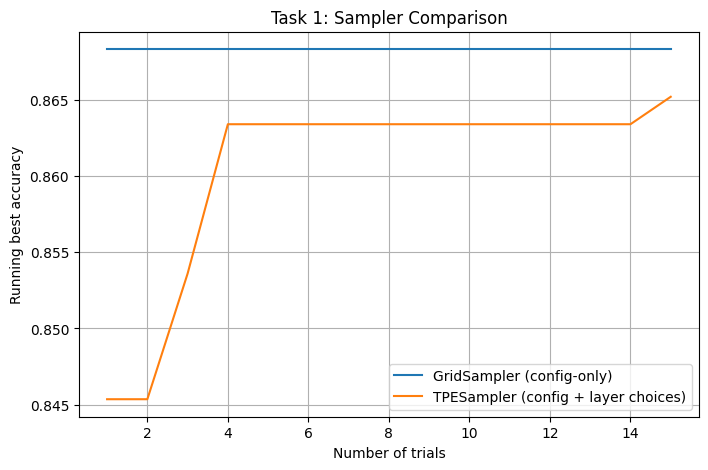

In [20]:
import optuna
import matplotlib.pyplot as plt
import torch
import gc
import torch.nn as nn
from pathlib import Path

from transformers import AutoConfig, AutoModelForSequenceClassification
from chop import MaseGraph
from chop.pipelines import CompressionPipeline
from chop.tools import get_trainer

# Make sure you have these already in your notebook:
# - dataset, tokenizer, checkpoint, search_space, out_dir (Path)

# ---------------------------
# Utility: running best curve
# ---------------------------
def running_best(study):
    best = float("-inf")
    xs, ys = [], []
    for t in sorted(study.trials, key=lambda x: x.number):
        if t.value is None:
            continue
        best = max(best, t.value)
        xs.append(len(xs) + 1)
        ys.append(best)
    return xs, ys

def cleanup(*objs):
    for o in objs:
        try:
            del o
        except:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ---------------------------
# Model constructors
#   - Grid: ONLY config params (NO per-layer suggest_categorical)
#   - TPE: your full construct_model(trial) (keeps layer choices)
# ---------------------------
def construct_model_grid_only(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # IMPORTANT: use the correct config field names for your model/config.
    # If your earlier construct_model worked, keep it consistent. (These are common for BERT-like configs.)
    for param in ["num_layers", "num_heads", "hidden_size", "intermediate_size"]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        # Map to actual config attribute names (BERT uses: num_hidden_layers, num_attention_heads, hidden_size, intermediate_size)
        if param == "num_layers":
            setattr(config, "num_hidden_layers", search_space[param][chosen_idx])
        elif param == "num_heads":
            setattr(config, "num_attention_heads", search_space[param][chosen_idx])
        else:
            setattr(config, param, search_space[param][chosen_idx])

    trial_model = AutoModelForSequenceClassification.from_config(config)
    return trial_model

# ---------------------------
# Objectives
# ---------------------------
def objective_grid(trial):
    model = construct_model_grid_only(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()
    eval_results = trainer.evaluate()

    acc = eval_results["eval_accuracy"]
    cleanup(trainer, model)
    return acc

def objective_tpe(trial):
    # Uses YOUR full NAS constructor with layer choices
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()
    eval_results = trainer.evaluate()

    acc = eval_results["eval_accuracy"]
    cleanup(trainer, model)
    return acc

# ---------------------------
# Compression-aware objective factory (Task 2)
#   Fixes device mismatch by forcing mg.model to trainer.args.device
# ---------------------------
def make_compression_objective(post_train: bool):
    def objective(trial):
        model = construct_model(trial)

        # pre-compression training
        trainer = get_trainer(
            model=model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1,
        )
        trainer.train()


        quantization_config = {
            "by": "type",
            "default": {"config": {"name": None}},
            "linear": {
                "config": {
                    "name": "integer",
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            },
        }

        pruning_config = {
            "weight": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
            "activation": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
        }

        mg = MaseGraph(model)
        pipe = CompressionPipeline()
        mg, _ = pipe(
            mg,
            pass_args={
                "quantize_transform_pass": quantization_config,
                "prune_transform_pass": pruning_config,
            },
        )


        if post_train:
            trainer2 = get_trainer(
                model=mg.model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
                num_train_epochs=1,
            )
            # Extra safety
            trainer2.model.to(trainer2.args.device)

            trainer2.train()
            eval_results = trainer2.evaluate()
            acc = eval_results["eval_accuracy"]
            cleanup(trainer2, trainer, pipe, mg, model)
            return acc
        else:
            trainer_eval = get_trainer(
                model=mg.model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
                num_train_epochs=0,  # ok; we only call evaluate()
            )
            trainer_eval.model.to(trainer_eval.args.device)

            eval_results = trainer_eval.evaluate()
            acc = eval_results["eval_accuracy"]
            cleanup(trainer_eval, trainer, pipe, mg, model)
            return acc

    return objective

# ---------------------------
# TASK 1: GridSampler vs TPESampler
# ---------------------------
n_trials = 15

grid_sampler = optuna.samplers.GridSampler({
    "num_layers": list(range(len(search_space["num_layers"]))),
    "num_heads": list(range(len(search_space["num_heads"]))),
    "hidden_size": list(range(len(search_space["hidden_size"]))),
    "intermediate_size": list(range(len(search_space["intermediate_size"]))),
})

tpe_sampler = optuna.samplers.TPESampler(seed=0)

study_grid = optuna.create_study(direction="maximize", sampler=grid_sampler)
study_grid.optimize(objective_grid, n_trials=n_trials)

study_tpe = optuna.create_study(direction="maximize", sampler=tpe_sampler)
study_tpe.optimize(objective_tpe, n_trials=n_trials)

xg, yg = running_best(study_grid)
xt, yt = running_best(study_tpe)

plt.figure(figsize=(8,5))
plt.plot(xg, yg, label="GridSampler (config-only)")
plt.plot(xt, yt, label="TPESampler (config + layer choices)")
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Task 1: Sampler Comparison")
plt.grid(True)
plt.legend()
plt.savefig(out_dir / "task1_sampler_comparison.png")
plt.show()

best_is_tpe = (yt[-1] if yt else float("-inf")) >= (yg[-1] if yg else float("-inf"))
best_sampler = tpe_sampler if best_is_tpe else grid_sampler
best_baseline_study = study_tpe if best_is_tpe else study_grid

[I 2026-02-01 01:33:12,159] A new study created in memory with name: no-name-16ddd39e-4901-4fc5-a34a-77f8a4220abb


[Task2] Task 1 best sampler is GridSampler, but your search space is dynamic.
       Switching to TPESampler for Task 2 to avoid grid param-name errors.


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.700500
1000,0.632700
1500,0.486500
2000,0.431500
2500,0.387400
3000,0.403800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 01:38:26,851] Trial 0 finished with value: 0.76756 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with

Step,Training Loss
500,0.692700
1000,0.616300
1500,0.476200
2000,0.419700
2500,0.408900
3000,0.406200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 01:41:45,575] Trial 1 finished with value: 0.76284 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with

Step,Training Loss
500,0.694800
1000,0.534800
1500,0.429900
2000,0.376300
2500,0.345900
3000,0.353600


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 01:45:02,002] Trial 2 finished with value: 0.75852 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 0 with value: 0.76

Step,Training Loss
500,0.644100
1000,0.487400
1500,0.421000
2000,0.375400
2500,0.343400
3000,0.345100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 01:50:46,388] Trial 3 finished with value: 0.72892 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1

Step,Training Loss
500,0.642600
1000,0.484900
1500,0.422000
2000,0.380500
2500,0.344700
3000,0.341200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 01:56:49,641] Trial 4 finished with value: 0.74484 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.l

Step,Training Loss
500,0.663400
1000,0.502200
1500,0.425300
2000,0.379700
2500,0.349500
3000,0.352700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:02:09,567] Trial 5 finished with value: 0.66868 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 0 with va

Step,Training Loss
500,0.694000
1000,0.642000
1500,0.537300
2000,0.464300
2500,0.402200
3000,0.398300


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:06:14,760] Trial 6 finished with value: 0.77884 and parameters: {'num_layers': 2, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 6 with value

Step,Training Loss
500,0.693000
1000,0.621200
1500,0.453200
2000,0.402400
2500,0.376100
3000,0.371500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:08:37,346] Trial 7 finished with value: 0.8336 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 7 with value: 0.

Step,Training Loss
500,0.668800
1000,0.536700
1500,0.475300
2000,0.429300
2500,0.371600
3000,0.369700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:14:07,462] Trial 8 finished with value: 0.69148 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 7 with va

Step,Training Loss
500,0.694500
1000,0.597700
1500,0.503700
2000,0.446800
2500,0.403100
3000,0.397900


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:17:21,605] Trial 9 finished with value: 0.78772 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 1, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 7 with va

Step,Training Loss
500,0.693900
1000,0.561300
1500,0.453800
2000,0.398000
2500,0.357800
3000,0.373100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:20:43,876] Trial 10 finished with value: 0.7626 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 7 with value: 0

Step,Training Loss
500,0.688200
1000,0.538200
1500,0.432300
2000,0.384900
2500,0.353400
3000,0.357900


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:23:59,043] Trial 11 finished with value: 0.8238 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 7 with va

Step,Training Loss
500,0.690700
1000,0.602100
1500,0.458900
2000,0.418400
2500,0.386000
3000,0.389300


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:26:35,903] Trial 12 finished with value: 0.77584 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 7 with v

Step,Training Loss
500,0.682900
1000,0.509300
1500,0.437300
2000,0.385600
2500,0.358200
3000,0.354700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:30:10,211] Trial 13 finished with value: 0.83828 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 13 with val

Step,Training Loss
500,0.678500
1000,0.519300
1500,0.446100
2000,0.401100
2500,0.369800
3000,0.358900


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-01 02:33:44,955] Trial 14 finished with value: 0.79832 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 2, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 13 with value:

Step,Training Loss
500,0.692700
1000,0.579400
1500,0.498000
2000,0.435500
2500,0.397600
3000,0.391700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.378800
1000,0.316400
1500,0.303500
2000,0.289600
2500,0.295200
3000,0.323800


[I 2026-02-01 02:40:56,756] Trial 0 finished with value: 0.84408 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 0 with value: 0

Step,Training Loss
500,0.693900
1000,0.626900
1500,0.517000
2000,0.459700
2500,0.413800
3000,0.413500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.390500
1000,0.306600
1500,0.322900
2000,0.316000
2500,0.307900
3000,0.347400


[I 2026-02-01 02:45:55,119] Trial 1 finished with value: 0.85644 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 1 w

Step,Training Loss
500,0.665000
1000,0.505200
1500,0.445000
2000,0.394500
2500,0.359700
3000,0.355100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.353400
1000,0.273300
1500,0.278600
2000,0.269800
2500,0.277600
3000,0.310800


[I 2026-02-01 02:55:58,637] Trial 2 finished with value: 0.86836 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 3, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value: 0.86

Step,Training Loss
500,0.688300
1000,0.534800
1500,0.418900
2000,0.373000
2500,0.343100
3000,0.356500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.313000
1000,0.269900
1500,0.265200
2000,0.269200
2500,0.274800
3000,0.313100


[I 2026-02-01 03:03:40,506] Trial 3 finished with value: 0.854 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 2, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 2 with value: 0.8

Step,Training Loss
500,0.668800
1000,0.533000
1500,0.449000
2000,0.392000
2500,0.350100
3000,0.353400


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.333600
1000,0.282300
1500,0.267200
2000,0.256100
2500,0.279800
3000,0.307700


[I 2026-02-01 03:15:59,856] Trial 4 finished with value: 0.80204 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value

Step,Training Loss
500,0.681900
1000,0.545700
1500,0.479800
2000,0.450600
2500,0.420100
3000,0.415400


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.390300
1000,0.330500
1500,0.329000
2000,0.330700
2500,0.332000
3000,0.342000


[I 2026-02-01 03:26:32,816] Trial 5 finished with value: 0.85264 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value

Step,Training Loss
500,0.661600
1000,0.494500
1500,0.404100
2000,0.379500
2500,0.338400
3000,0.347800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.316000
1000,0.268700
1500,0.261600
2000,0.274800
2500,0.277800
3000,0.309300


[I 2026-02-01 03:37:02,702] Trial 6 finished with value: 0.85988 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value: 0

Step,Training Loss
500,0.696900
1000,0.591600
1500,0.455300
2000,0.396500
2500,0.360200
3000,0.348400


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.340300
1000,0.279900
1500,0.271800
2000,0.280600
2500,0.281100
3000,0.311700


[I 2026-02-01 03:46:00,512] Trial 7 finished with value: 0.85772 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 2 with

Step,Training Loss
500,0.684900
1000,0.543500
1500,0.437900
2000,0.383900
2500,0.361900
3000,0.354100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.345400
1000,0.268700
1500,0.294900
2000,0.287000
2500,0.292200
3000,0.313900


[I 2026-02-01 03:52:23,316] Trial 8 finished with value: 0.86968 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 8 with value

Step,Training Loss
500,0.689300
1000,0.508600
1500,0.417100
2000,0.366600
2500,0.353600
3000,0.360200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.317400
1000,0.252700
1500,0.269200
2000,0.276200
2500,0.275600
3000,0.313100


[I 2026-02-01 03:59:28,591] Trial 9 finished with value: 0.87268 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 9 with value

Step,Training Loss
500,0.665700
1000,0.542700
1500,0.496200
2000,0.465300
2500,0.427200
3000,0.419000


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.396800
1000,0.318600
1500,0.320600
2000,0.309500
2500,0.305300
3000,0.320400


[I 2026-02-01 04:11:26,890] Trial 10 finished with value: 0.8526 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 4, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 9 with

Step,Training Loss
500,0.692000
1000,0.619100
1500,0.451700
2000,0.395700
2500,0.369400
3000,0.378800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.356100
1000,0.290000
1500,0.301700
2000,0.301600
2500,0.286800
3000,0.329300


[I 2026-02-01 04:16:23,870] Trial 11 finished with value: 0.87064 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 9 with valu

Step,Training Loss
500,0.693300
1000,0.615400
1500,0.467200
2000,0.415400
2500,0.375900
3000,0.379700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.362400
1000,0.293600
1500,0.301900
2000,0.304400
2500,0.295200
3000,0.329800


[I 2026-02-01 04:21:22,417] Trial 12 finished with value: 0.86764 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 9 with value: 

Step,Training Loss
500,0.691300
1000,0.633500
1500,0.467300
2000,0.410700
2500,0.376800
3000,0.388100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.355900
1000,0.293100
1500,0.298300
2000,0.312600
2500,0.293600
3000,0.339700


[I 2026-02-01 04:25:25,879] Trial 13 finished with value: 0.87088 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 9 wit

Step,Training Loss
500,0.691300
1000,0.633500
1500,0.467300
2000,0.410700
2500,0.376800
3000,0.388100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.356200
1000,0.291700
1500,0.299800
2000,0.314400
2500,0.294200
3000,0.337400


[I 2026-02-01 04:29:29,219] Trial 14 finished with value: 0.8712 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 9 with

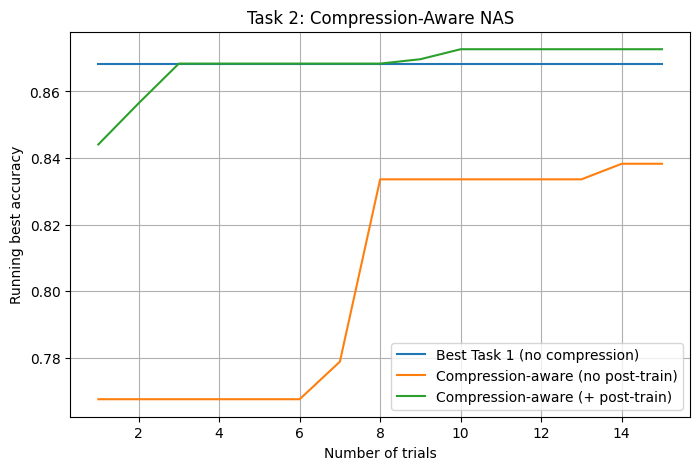

In [26]:
import optuna
import matplotlib.pyplot as plt
import torch
import gc
import time

from chop import MaseGraph
import chop.passes as passes
from chop.pipelines import CompressionPipeline
from chop.tools import get_trainer

# ---------------------------
# Utility: running best curve
# ---------------------------
def running_best(study):
    best = float("-inf")
    xs, ys = [], []
    for t in sorted(study.trials, key=lambda x: x.number):
        if t.value is None:
            continue
        best = max(best, t.value)
        xs.append(len(xs) + 1)
        ys.append(best)
    return xs, ys

def cleanup(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ---------------------------
# Pick a sampler that works with dynamic / conditional search spaces
# ---------------------------
def pick_task2_sampler(best_sampler_from_task1, seed: int = 0):
    """
    GridSampler cannot handle dynamic parameter names / conditional spaces.
    If Task 1 "best" is GridSampler, fall back to TPE for Task 2.
    """
    from optuna.samplers import GridSampler, TPESampler

    if isinstance(best_sampler_from_task1, GridSampler):
        print(
            "[Task2] Task 1 best sampler is GridSampler, but your search space is dynamic.\n"
            "       Switching to TPESampler for Task 2 to avoid grid param-name errors."
        )
        return TPESampler(seed=seed)

    # Otherwise, use whatever was best in Task 1 (e.g., TPE)
    return best_sampler_from_task1

# ---------------------------
# TASK 2: Compression-aware objective (CompressionPipeline + CPU-safe compression)
# ---------------------------
def make_compression_objective(
    post_train: bool,
    pre_epochs: int = 1,
    post_epochs: int = 1,
):
    """
    Required flow:
      1) model = construct_model(trial)
      2) train for a few epochs
      3) CompressionPipeline quantize+prune
      4) (optional) post-train for a few epochs
      5) return final eval accuracy
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    HF_INPUT_NAMES = ["input_ids", "attention_mask", "labels"]

    def objective(trial):
        trainer_pre = None
        trainer_post = None
        trainer_eval = None
        mg = None
        pipe = None

        # IMPORTANT: define configs inside objective so nothing gets mutated across trials
        quantization_config = {
            "by": "type",
            "default": {"config": {"name": None}},
            "linear": {
                "config": {
                    "name": "integer",
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            },
        }

        pruning_config = {
            "weight": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
            "activation": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
        }

        try:
            # 1) Build model (your Task 1 NAS function)
            model = construct_model(trial)
            model.config.problem_type = "single_label_classification"

            # 2) Pre-compression training (GPU)
            model = model.to(device)
            trainer_pre = get_trainer(
                model=model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
                num_train_epochs=pre_epochs,
            )
            trainer_pre.train()
            trained_model = trainer_pre.model

            # 3) Move to CPU BEFORE CompressionPipeline (prevents CPU/CUDA dummy-forward mismatch)
            trained_model_cpu = trained_model.to("cpu")

            # 4) Build graph + metadata (like Tutorial 3/4)
            mg = MaseGraph(trained_model_cpu, hf_input_names=HF_INPUT_NAMES)
            mg, _ = passes.init_metadata_analysis_pass(mg)
            mg, _ = passes.add_common_metadata_analysis_pass(mg)

            # 5) CompressionPipeline in-trial (required by Task 2)
            pipe = CompressionPipeline()
            mg, _ = pipe(
                mg,
                pass_args={
                    "quantize_transform_pass": quantization_config,
                    "prune_transform_pass": pruning_config,
                },
            )

            # 6) Back to GPU for eval / post-train
            mg.model = mg.model.to(device)

            if post_train:
                trainer_post = get_trainer(
                    model=mg.model,
                    tokenized_dataset=dataset,
                    tokenizer=tokenizer,
                    evaluate_metric="accuracy",
                    num_train_epochs=post_epochs,
                )
                trainer_post.train()
                eval_results = trainer_post.evaluate()
            else:
                trainer_eval = get_trainer(
                    model=mg.model,
                    tokenized_dataset=dataset,
                    tokenizer=tokenizer,
                    evaluate_metric="accuracy",
                    num_train_epochs=0,
                )
                eval_results = trainer_eval.evaluate()

            return float(eval_results["eval_accuracy"])

        finally:
            cleanup(trainer_pre, trainer_post, trainer_eval, mg, pipe)

    return objective

# ---------------------------
# RUN Task 2 studies
# Requires you already have:
#   - best_baseline_study (Task 1 best-performing study object)
#   - best_sampler (Task 1 best sampler object)
#   - n_trials
#   - out_dir (Path)
#   - dataset, tokenizer
#   - construct_model(trial)
# ---------------------------

task2_sampler = pick_task2_sampler(best_sampler, seed=0)

study_comp_no_post = optuna.create_study(direction="maximize", sampler=task2_sampler)
study_comp_no_post.optimize(
    make_compression_objective(post_train=False, pre_epochs=1, post_epochs=1),
    n_trials=n_trials,
)

study_comp_post = optuna.create_study(direction="maximize", sampler=task2_sampler)
study_comp_post.optimize(
    make_compression_objective(post_train=True, pre_epochs=1, post_epochs=1),
    n_trials=n_trials,
)

# ---------------------------
# Plot required curves
# ---------------------------
xb, yb = running_best(best_baseline_study)
xn, yn = running_best(study_comp_no_post)
xp, yp = running_best(study_comp_post)

plt.figure(figsize=(8, 5))
plt.plot(xb, yb, label="Best Task 1 (no compression)")
plt.plot(xn, yn, label="Compression-aware (no post-train)")
plt.plot(xp, yp, label="Compression-aware (+ post-train)")
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Task 2: Compression-Aware NAS")
plt.grid(True)
plt.legend()
plt.savefig(out_dir / "task2_compression_aware_nas.png")
plt.show()
